# STABILITY of FEATURE INFLUENCE

A simple method to reduce features is to run a linear regression to see if there is any feature which reports a parameter estimate which is statistically significant.

$$y=\beta X+\epsilon$$

Note that $\beta$ and $X$ are matrices in this context. A significant feature $i$ has a $\beta_i\neq 0$ with 95% certainty. 

# Preprocessing
Import libraries and data

In [1]:
# external
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm
# internal
from utils.import_data import importData
from utils.model_tester import ModelTester
import utils.nicer_plots

In [2]:
file_data = "data2.csv"
file_labels = "labels2.csv"
n_features = -1
directory = "\data\\"

data, labels = importData(file_data, file_labels, directory, n_features, iterations=True)

Number of samples:    102400
Number of features:   3851


# Linear Regression

First, we simply fit the model and look at the distribution of $\beta_i$ to each feature $i$.

In [3]:
import statsmodels.api as sm
model = sm.OLS(labels['binary-label'].values,data.values)
fitted_model = model.fit()

With this we get 3851 beta parameters, with each a confidence interval and a probability of signifance of their own. This is naturally difficult to visualize, so here are the first 3 features:

In [4]:
fitted_model.summary2().tables[1].head(3)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
x1,1.611558e-10,1.753799e-10,0.918896,0.358152,-1.825867e-10,5.048983e-10
x2,-2.094802e-10,1.722270e-10,-1.216303,0.223872,-5.470430e-10,1.280826e-10
x3,2.133682e-10,2.163528e-10,0.986205,0.324035,-2.106807e-10,6.374170e-10


Now let's take a look at significant parameters

In [5]:
p_values = fitted_model.summary2().tables[1]['P>|t|']
print("Number of significant (95%) p-values: ",len(p_values[p_values>0.95]))

Number of significant (95%) p-values:  183


This is a bit more than expected if it was truly random. Out of 3851 parameters, we would expect 193 to be significant from if we set our level of significance to 95% (if it was truly random).

## 50/50 split
If we split the data in 2 independent sets. If features are truly significant, they should show up when regressing on both data sets. 

In [6]:
all_sign_50 = []
N = data.shape[0]
p = 0.5 # percent True (roughly)

filt = np.random.choice(a=[True, False], size=N, p=[p, 1-p]) 
filt_inverse = [not x for x in filt]

for f in tqdm([filt,filt_inverse]):
    y = labels['binary-label'][f].values
    X = data[f].values
    model = sm.OLS(y,X)
    fitted_model = model.fit()
    p_values = fitted_model.summary2().tables[1]['P>|t|']
    sign_vars = p_values[p_values>0.95].index
    all_sign_50 += list(sign_vars)

counter_50=collections.Counter(all_sign_50)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [09:48<00:00, 294.41s/it]


In [7]:
print("Number of features shown twice:", len([x for x in list(counter_50.values()) if x==2]))
print("Total number of features:",len(counter_50.values()))

Number of features shown twice: 13
Total number of features: 421


If it was truly random, we would expect 10 to show up twice and 386 in total. This isn't too far off, so it might just be random noise we are getting. Either way, let's test and see if the selected features are useful.

# Putting it into practice
Let's see if we can use this as a true feature selection before we run it through an rbf svm (which otherwise has been shown to be promising).



In [8]:
# Only use the significant features found before.
# Train these on svm with rbf kernel (see that seperate file for more information
# Look at results.

In [9]:
from sklearn.svm import SVC # support vector classifier
from warnings import filterwarnings
filterwarnings('ignore') # :)

## Small subset
We filter out the features which appeared **twice** in the 50/50 split. Only 7!

In [10]:
data.columns = model.exog_names # match name of features
data_most_sig = data[[x for x in list(counter_50.keys()) if counter_50[x]>1]]
mt = ModelTester(data_most_sig, labels, SVC) # initiate testing environment for our models

In [11]:
parameters = {'C':[0.001,0.005,0.01,0.05,.1,0.5,1], # relaxation paramater
              'gamma':[0.001,0.01,0.05,.1,0.5,1], # weight
              'kernel':['rbf'],
              'max_iter':[10**3],
              'probability':[True]}
# running the brute force function
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 4,score="balanced_accuracy",update_parameters=True, sampling = 'under', **parameters);

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [13:55<00:00, 19.89s/it]


   Ranking      C    gamma  kernel      max_iter  probability      balanced_accuracy    Standard deviation
---------  -----  -------  --------  ----------  -------------  -------------------  --------------------
        1  0.005     0.01  rbf             1000  True                      0.501148           0.00295372
        2  1         0.5   rbf             1000  True                      0.500521           0.011454
        3  0.01      0.01  rbf             1000  True                      0.500457           0.00100931
        4  0.01      0.5   rbf             1000  True                      0.500018           0.00208857
        5  0.5       0.1   rbf             1000  True                      0.500012           0.00203356
        6  0.001     0.01  rbf             1000  True                      0.49951            0.00335906
        7  0.05      0.5   rbf             1000  True                      0.499406           0.000641205
        8  0.005     0.5   rbf             1000  Tru

Best result is 50.1%... Further, the selected parameters do not seem stable, giving indication that it is random. 

Weighted accuracies:


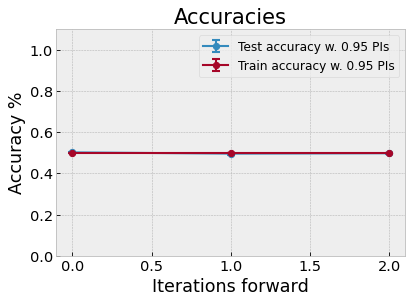

Test accuracies: [0.50165211 0.49575218 0.49749575]
Confusion matrices:


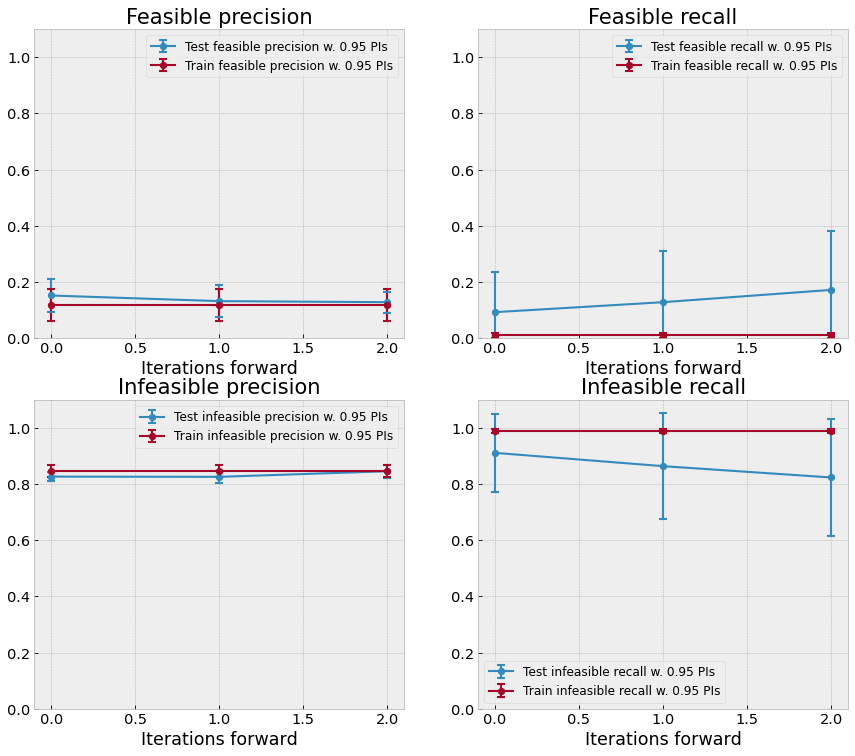

Percentage infeasible on test and train data:


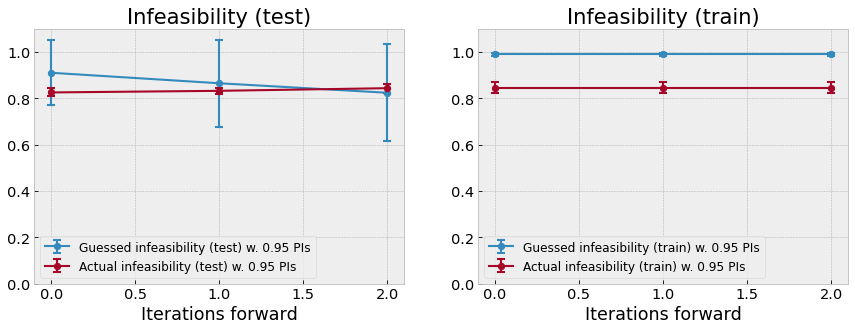

In [12]:
# run the training again on the best parameter! Now a few more time to get better estimates
mt.training_loop(sampling = 'over', printing=  False)
mt.plot_graphs(AUC = False) # Can't do AUC since no (true) probabilities are generated in SVMs

In [13]:
mt.print_essentials()

Results: 

variable                             average    std  95.0% PI           min     max
---------------------------------  ---------  -----  ---------------  -----  ------
weighted accuracy [%]                  50.17   0.4   (49.88, 50.45)   49.77   51.12
duration [s]                            3.64   0.34  (3.4, 3.88)       2.97    4.18
infeasible_percentage [%]              82.56   2.4   (80.85, 84.28)   77.25   85.45
infeasible_guessed_percentage [%]      91.05  19.59  (77.04, 105.07)  32.67  100
feasible_recall [%]                     9.22  19.86  (-4.99, 23.42)    0      68.24
feasible_precision [%]                 15.15   7.99  (9.44, 20.87)     0      23.21
infeasible_recall [%]                  91.11  19.51  (77.15, 105.07)  32.93  100
infeasible_precision [%]               82.66   2.3   (81.01, 84.3)    77.88   85.46
auc of roc                              0.5    0.01  (0.5, 0.51)       0.49    0.52


No fruitful result. Still hoovering around 50%. And our 95% prediction interval is below 50%.

## Slightly bigger subset of features
Let's take **all** the features which showed to be significant in the 50/50 split.

In [14]:
data_sig = data[list(counter_50.keys())]
mt = ModelTester(data_sig, labels, SVC) # initiate testing environment for our models

In [15]:
parameters = {'C':[0.001,0.005,0.01,0.05,.1,0.5,1], # relaxation paramater
              'gamma':[0.001,0.01,0.05,.1,0.5,1], # weight
              'kernel':['rbf'],
              'max_iter':[10**3],
              'probability':[True]}
# running the brute force function
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 1, score = "balanced_accuracy", update_parameters = True, sampling = 'under', **parameters)

100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [2:15:40<00:00, 193.83s/it]


   Ranking      C    gamma  kernel      max_iter  probability      balanced_accuracy    Standard deviation
---------  -----  -------  --------  ----------  -------------  -------------------  --------------------
        1  0.5      0.05   rbf             1000  True                      0.515026                     0
        2  0.05     0.05   rbf             1000  True                      0.513583                     0
        3  1        0.05   rbf             1000  True                      0.511927                     0
        4  0.05     0.01   rbf             1000  True                      0.509595                     0
        5  0.1      0.001  rbf             1000  True                      0.509223                     0
        6  0.1      0.05   rbf             1000  True                      0.507718                     0
        7  1        0.1    rbf             1000  True                      0.50622                      0
        8  0.001    0.1    rbf             1

{'C': 0.5,
 'gamma': 0.05,
 'kernel': 'rbf',
 'max_iter': 1000,
 'probability': True}

**Note** that the standard deviation is equal to zero since every model was trained only once. So we have a high risk of the best results stemming from chance.

Again, not great results. Moreso, it doesn't find the same parameter estimates. Which draws to the idea that there is nothing of value to find here.

Weighted accuracies:


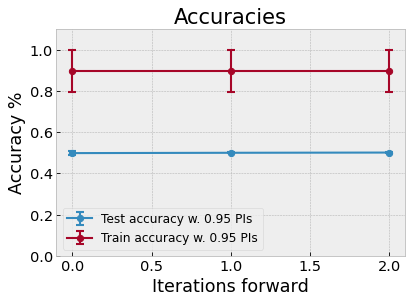

Test accuracies: [0.49818738 0.49974402 0.50087414]
Confusion matrices:


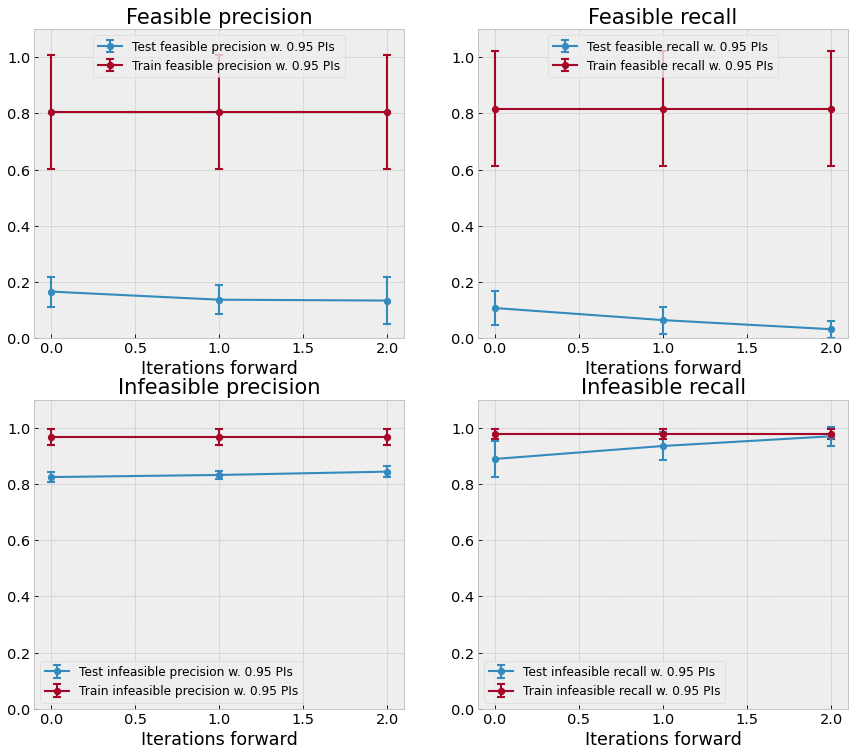

Percentage infeasible on test and train data:


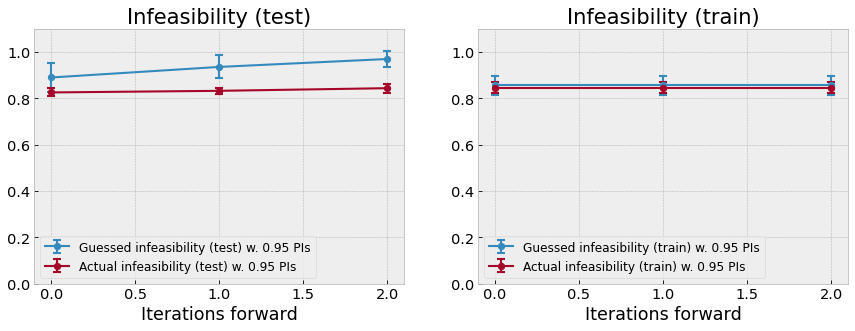

In [16]:
# run the training again on the best parameter! Now a few more time to get better estimates
mt.training_loop(sampling = 'over', printing = False)
mt.plot_graphs(AUC = False) # Can't do AUC since no (true) probabilities are generated in SVMs

In [17]:
mt.print_essentials()

Results: 

variable                             average    std  95.0% PI          min     max
---------------------------------  ---------  -----  --------------  -----  ------
weighted accuracy [%]                  49.82   1.3   (48.89, 50.75)  46.39   51.5
duration [s]                           60.81   2.75  (58.85, 62.78)  56.92   64.94
infeasible_percentage [%]              82.56   2.4   (80.85, 84.28)  77.25   85.45
infeasible_guessed_percentage [%]      89.01   8.82  (82.7, 95.32)   73.39  100
feasible_recall [%]                    10.7    8.7   (4.47, 16.92)    0      29.12
feasible_precision [%]                 16.54   7.46  (11.21, 21.88)   0      31.82
infeasible_recall [%]                  88.94   8.93  (82.55, 95.33)  73.89  100
infeasible_precision [%]               82.49   2.51  (80.69, 84.29)  77.34   85.35
auc of roc                              0.49   0.02  (0.48, 0.5)      0.46    0.51


Again, we see a prediction inteval fall below 95% 

# Conclusion
It's difficult to estimate the expected value here since we have a bit too few observations to get good estimates. We did get a few features which showed to be significant, but that is of course also expected depending on your chosen confidence interval - and the results we got look random. Either way, filtering out insignificant features did not seem to yield any fruitful results. 